## Solution Approach

**Problem Statement** - To predict if an existing customer of a car insurance company will raise a claim in the upcoming 6 months or not.

Below are the steps taken to find an optimized model for the given classification problem:

* After loading the dataset and doing basic exploration, it is noticed that the event(claim raised by a customer) count is around 6%. Further, there are no missing values in the dataset.

*  From basic EDA, it is found out that there are more categorical and binary features in the dataset compared to the numerical feature. Further, there is no significant linear relationship between any feature and target variable.

*  The dataset is split into train and validation sets(90:10). The categorical variables are encoded using the WOE encoder.

*  Tree-based models generally works well for this type of class imbalance problem. So, the LIGHTGBM algorithm is used with Randomized search.

*  F1 score has been chosen as the evaluation metric as per the contest requirement. But, depending on the business setup, we can either use recall/precision as the evaluation metric. A detailed cost-benefit analysis of acquiring a customer vs claim payment needs to be done to solve the problem.

*  After getting the optimal hypermeters from randomized and manual search, the LIGHTGBM model is fitted with the entire training dataset.

*  F1 score on the validation set is 0.184 and the private score is 0.181.




In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from xverse.transformer import WOE
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.woe import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.feature_selection import RFE

C:\Users\6006917\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

### Load the dataset and do basic checks

In [3]:
df = pd.read_csv('train_qWM28Yl.csv')
oot = pd.read_csv('test_zo1G9sv.csv')

In [4]:
df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [5]:
df.shape

(58592, 44)

In [6]:
# check for duplicate IDs
df['policy_id'].duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [8]:
df['is_claim'].value_counts(normalize = True)

0    0.936032
1    0.063968
Name: is_claim, dtype: float64

In [9]:
df.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


### EDA

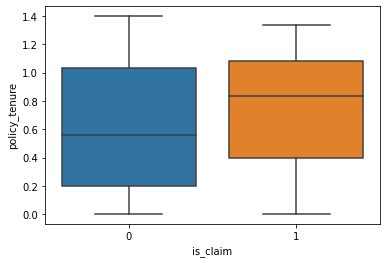

In [10]:
sns.boxplot(x = 'is_claim', y = 'policy_tenure', data = df)
plt.show()

<AxesSubplot:xlabel='is_claim', ylabel='age_of_car'>

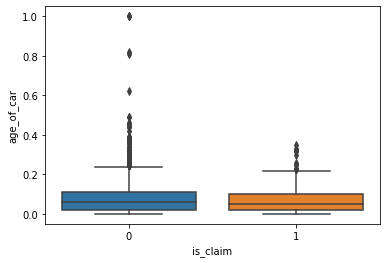

In [11]:
sns.boxplot(x = 'is_claim', y = 'age_of_car', data = df)

<AxesSubplot:xlabel='is_claim', ylabel='age_of_policyholder'>

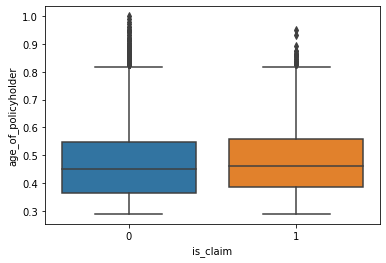

In [12]:
sns.boxplot(x = 'is_claim', y = 'age_of_policyholder', data = df)

<AxesSubplot:xlabel='area_cluster', ylabel='Density'>

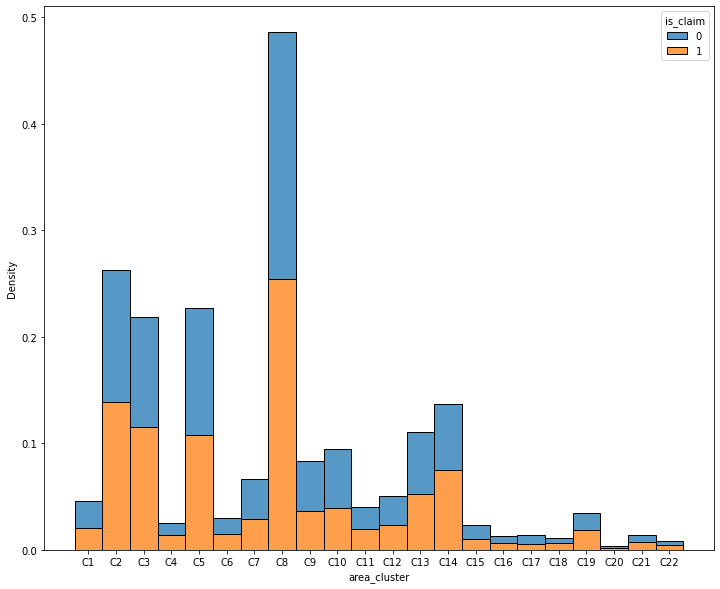

In [13]:
plt.figure(figsize = (12,10))
sns.histplot(x = 'area_cluster', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='is_claim', ylabel='population_density'>

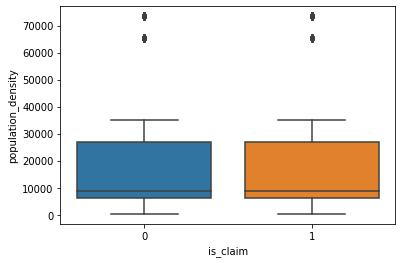

In [14]:
sns.boxplot(x = 'is_claim', y = 'population_density', data = df)

<AxesSubplot:xlabel='make', ylabel='Density'>

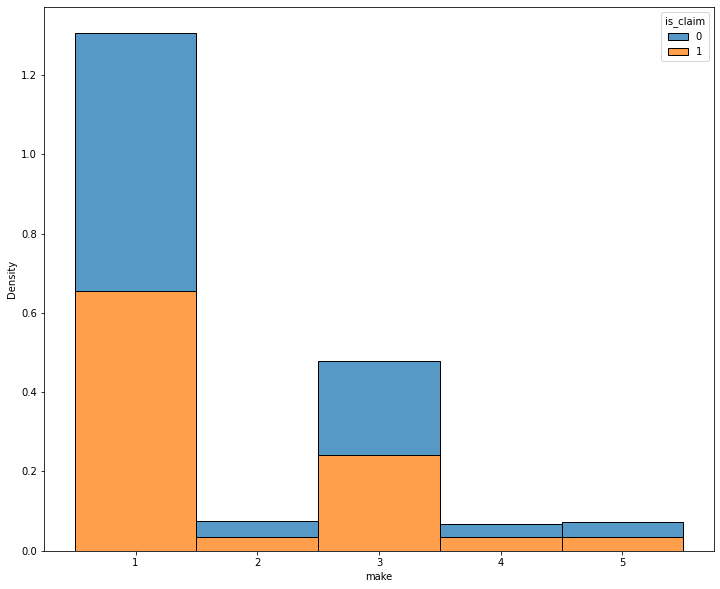

In [15]:
df['make'] = df['make'].astype('category')
plt.figure(figsize = (12,10))
sns.histplot(x = 'make', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='segment', ylabel='Density'>

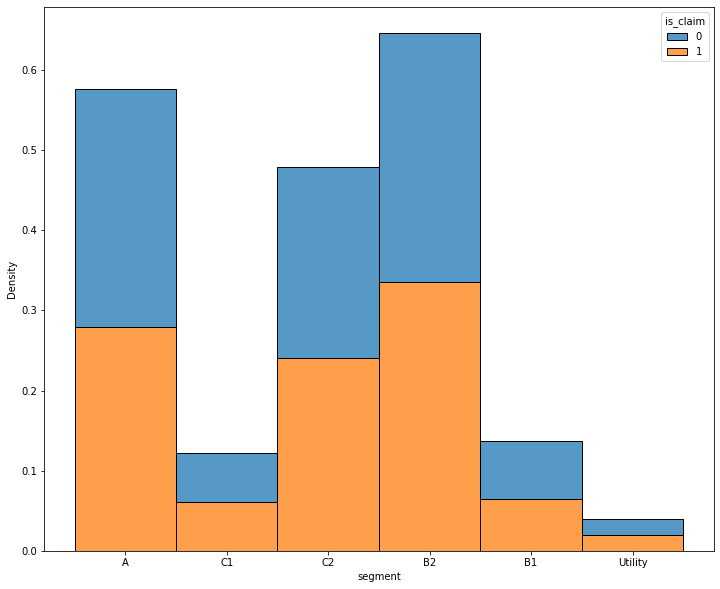

In [16]:
plt.figure(figsize = (12,10))
sns.histplot(x = 'segment', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='model', ylabel='Density'>

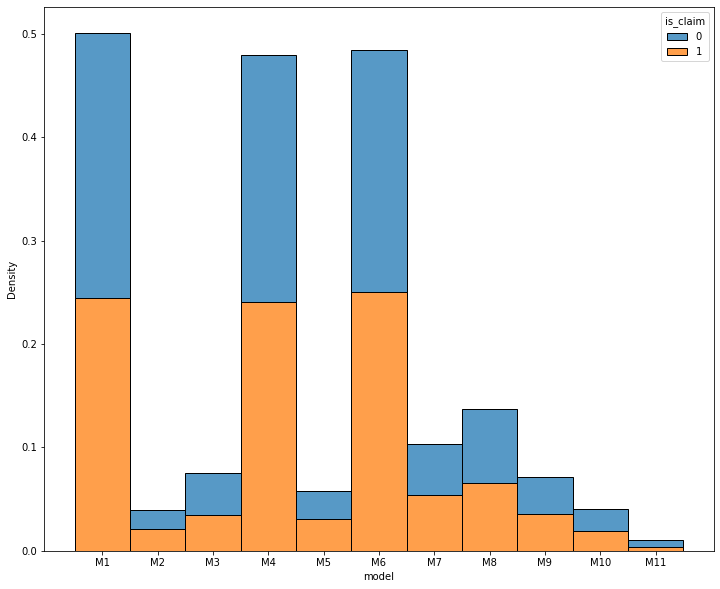

In [17]:
plt.figure(figsize = (12,10))
sns.histplot(x = 'model', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='fuel_type', ylabel='Density'>

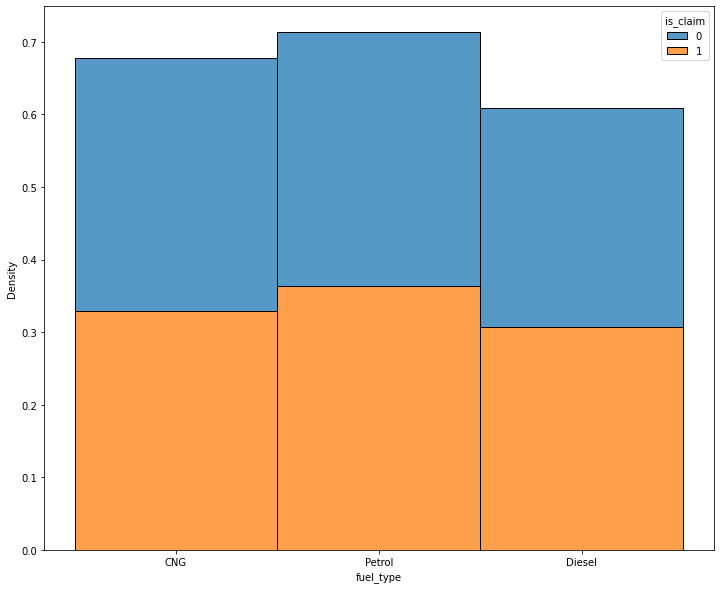

In [18]:
plt.figure(figsize = (12,10))
sns.histplot(x = 'fuel_type', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='max_torque', ylabel='Density'>

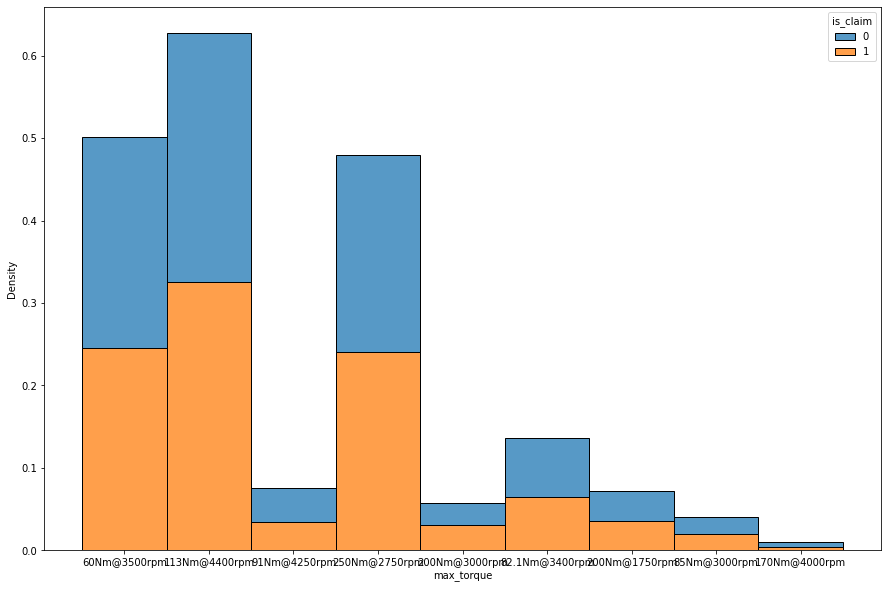

In [19]:
plt.figure(figsize = (15,10))
sns.histplot(x = 'max_torque', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='max_power', ylabel='Density'>

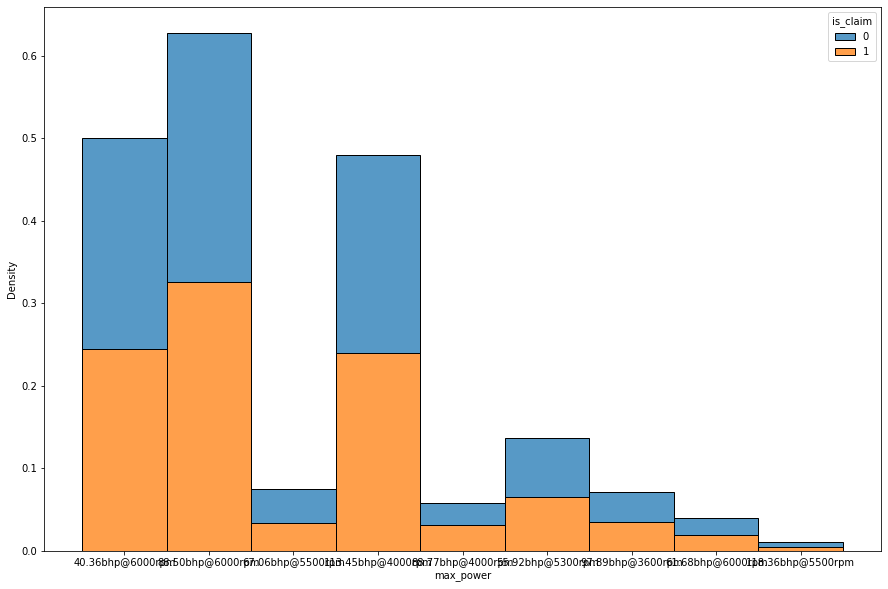

In [20]:
plt.figure(figsize = (15,10))
sns.histplot(x = 'max_power', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='engine_type', ylabel='Density'>

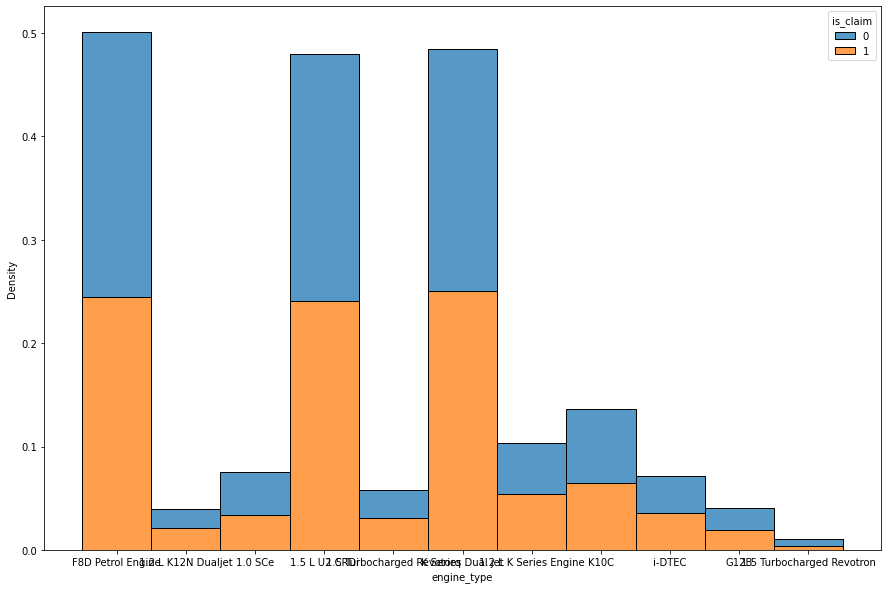

In [21]:
plt.figure(figsize = (15,10))
sns.histplot(x = 'engine_type', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='airbags', ylabel='Density'>

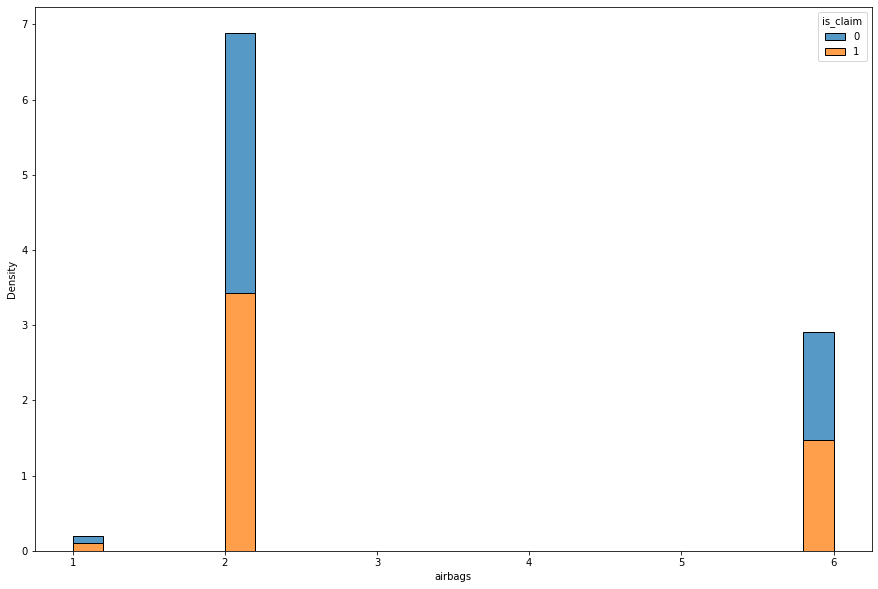

In [22]:
plt.figure(figsize = (15,10))
sns.histplot(x = 'airbags', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

<AxesSubplot:xlabel='is_esc', ylabel='Density'>

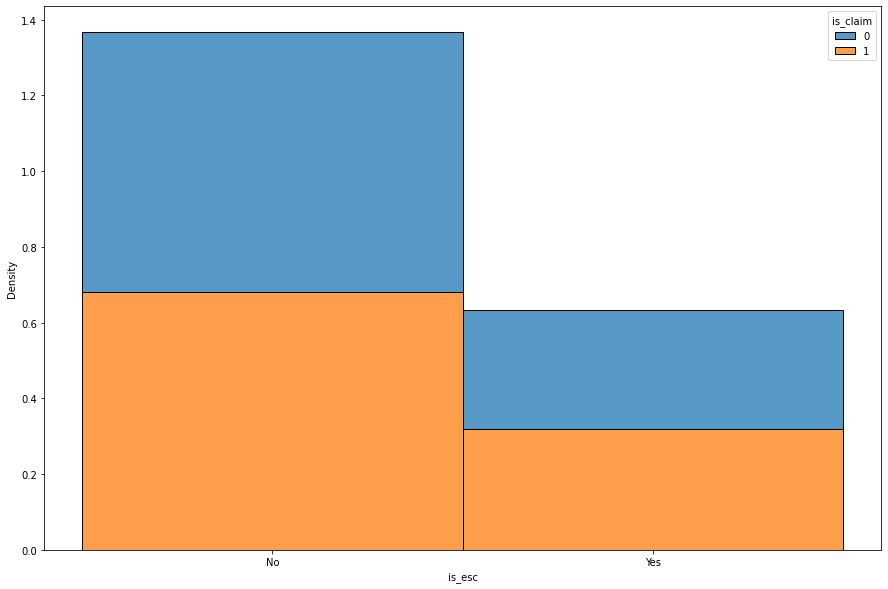

In [23]:
plt.figure(figsize = (15,10))
sns.histplot(x = 'is_esc', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False)

In [24]:
cols = ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera',
        'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
        'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering',
        'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']

for col in cols:
    df[col] = np.where(df[col] == 'Yes', 1, 0)
    
for col in cols:
    oot[col] = np.where(oot[col] == 'Yes', 1, 0)

### Train and Validation Split

In [25]:
X = df.drop(columns = ['policy_id', 'is_claim'])
y = df['is_claim']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 1)

In [27]:
y_train.value_counts(normalize = True)

0    0.936035
1    0.063965
Name: is_claim, dtype: float64

In [28]:
y_test.value_counts()

0    5485
1     375
Name: is_claim, dtype: int64

### Encoding

In [29]:
woe = WOEEncoder()

In [30]:
feature_list = ['area_cluster', 'make', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power', 'engine_type',
                 'rear_brakes_type', 'transmission_type', 'steering_type']

In [31]:
train_woe = woe.fit_transform(x_train[feature_list], y_train)
test_woe = woe.transform(x_test[feature_list])
oot_woe = woe.transform(oot[feature_list])

In [32]:
train_woe.shape

(52732, 11)

In [33]:
train_woe.head()

,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
42769,0.104014,0.012074,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
35051,0.104014,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
12127,0.116440,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
17456,0.127955,0.012074,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
17734,-0.087772,-0.007887,-0.007887,-0.007887,0.009051,-0.007887,-0.007887,-0.007887,-0.007887,-0.006683,-0.040718


In [34]:
x_train.drop(columns = feature_list, inplace = True)
x_test.drop(columns = feature_list, inplace = True)
oot.drop(columns = feature_list, inplace = True)

In [35]:
x_train_final = pd.concat([x_train, train_woe], axis = 1)
x_test_final = pd.concat([x_test, test_woe], axis = 1)
oot_final = pd.concat([oot, oot_woe], axis = 1)

In [36]:
x_train_final.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
42769,0.868744,0.08,0.346154,8794,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.104014,0.012074,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
35051,0.383458,0.00,0.509615,8794,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.104014,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
12127,0.869126,0.00,0.423077,4076,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.116440,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
17456,0.766596,0.01,0.307692,27742,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.127955,0.012074,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
17734,0.031597,0.06,0.298077,5410,6,1,1,1,1,1,1493,4,6,5.2,4300,1790,1635,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,-0.087772,-0.007887,-0.007887,-0.007887,0.009051,-0.007887,-0.007887,-0.007887,-0.007887,-0.006683,-0.040718


In [37]:
x_test_final.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
24307,0.867852,0.02,0.653846,4076,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.116440,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
57327,1.090563,0.17,0.451923,8794,2,0,1,0,1,1,1498,4,5,4.9,3995,1695,1501,1051,1,0,0,1,0,1,1,1,1,1,1,1,4,0.104014,-0.029199,-0.010470,-0.029199,0.009051,-0.029199,-0.029199,-0.029199,0.002479,0.003574,0.054712
24703,1.088634,0.18,0.423077,8794,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.104014,0.012074,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
40585,0.913375,0.01,0.605769,4076,6,1,1,1,1,1,1493,4,6,5.2,4300,1790,1635,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,0.116440,-0.007887,-0.007887,-0.007887,0.009051,-0.007887,-0.007887,-0.007887,-0.007887,-0.006683,-0.040718
17527,0.745566,0.04,0.576923,6108,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.105572,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718


In [38]:
oot_final.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
0,ID58593,0.341732,0.00,0.586538,4076,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.116440,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
1,ID58594,0.307241,0.13,0.442308,8794,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.104014,0.012074,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
2,ID58595,0.327924,0.12,0.451923,8794,2,0,0,0,0,1,999,3,5,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0.104014,-0.212061,-0.060953,-0.212061,0.043882,-0.212061,-0.212061,-0.212061,0.002479,-0.006683,0.054712
3,ID58596,0.782654,0.01,0.461538,34738,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.095075,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
4,ID58597,1.233404,0.02,0.634615,34738,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.095075,0.012074,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718


### Feature Selection

In [39]:
#x_train_final.corr()

In [40]:
# rfe = RFE(estimator = RandomForestClassifier(class_weight = 'balanced'), n_features_to_select = 10)

# pipe = Pipeline([('rfe',rfe)])
# transformed_df_rfe = pipe.fit_transform(x_train_final, y_train)
# support = pipe.named_steps['rfe'].support_
# drop_cols_rfe = list(x_train_final.columns[support])

In [41]:
# drop_cols_rfe

In [42]:
# # highly multicolinear variables
# cols_to_drop = ['is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger',
#                'gear_box', 'is_tpms', 'is_esc', 'cylinder', 'engine_type', 'max_torque', 'max_power']

In [43]:
# x_train_final.drop(columns = cols_to_drop, inplace = True)
# x_test_final.drop(columns = cols_to_drop, inplace = True)
# oot_final.drop(columns = cols_to_drop, inplace = True)

### Model building

In [44]:
# fit_params={"early_stopping_rounds": 30, 
#             "eval_metric" : 'f1', 
#             "eval_set" : [(x_test_final,y_test)],
#             'eval_names': ['valid'],
#             'verbose': 100}

In [45]:
param_space ={'num_leaves': [8, 12, 16, 20, 25],  
             'subsample': [0.5, 0.7, 0.9], 
             'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8],
             'reg_alpha': [0, 1e-1, 1, 5, 7, 10, 50],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 50],
             'learning_rate': [0.015, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
             'n_estimators': [100, 120, 140, 150]}

In [46]:
lgbm = LGBMClassifier(objective = 'binary', is_unbalance = True, random_state = 1)

In [47]:
search = RandomizedSearchCV(estimator = lgbm, param_distributions = param_space, n_iter = 100,
                            scoring ='f1', cv=3, random_state = 1, verbose = True)
search.fit(x_train_final, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            objective='binary',
                                            random_state=1),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8],
                                        'learning_rate': [0.015, 0.02, 0.03,
                                                          0.05, 0.07, 0.1, 0.2,
                                                          0.3],
                                        'n_estimators': [100, 120, 140, 150],
                                        'num_leaves': [8, 12, 16, 20, 25],
                                        'reg_alpha': [0, 0.1, 1, 5, 7, 10, 50],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 50],
                                        'subsample': [0.5, 0.7, 0.9]},
     

In [50]:
search.best_score_

0.17109874054154486

In [51]:
search.best_params_

{'subsample': 0.5,
 'reg_lambda': 1,
 'reg_alpha': 7,
 'num_leaves': 20,
 'n_estimators': 120,
 'learning_rate': 0.02,
 'colsample_bytree': 0.4}

In [52]:
lgbm_best = LGBMClassifier(objective = 'binary',
                           colsample_bytree = 0.4,
                           subsample = 0.5,
                           is_unbalance = True,
                          learning_rate = 0.02,
                          num_leaves = 15,
                           max_depth = 5,
                           reg_lambda = 1,
                           reg_alpha = 7,
                           n_estimators = 100,
                          random_state = 1)

In [53]:
lgbm_best.fit(x_train_final, y_train)

LGBMClassifier(colsample_bytree=0.4, is_unbalance=True, learning_rate=0.02,
               max_depth=5, num_leaves=15, objective='binary', random_state=1,
               reg_alpha=7, reg_lambda=1, subsample=0.5)

In [54]:
y_pred = lgbm_best.predict(x_test_final)
print(classification_report(y_test, y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.952     0.781     0.858      5485
           1      0.117     0.427     0.184       375

    accuracy                          0.758      5860
   macro avg      0.535     0.604     0.521      5860
weighted avg      0.899     0.758     0.815      5860



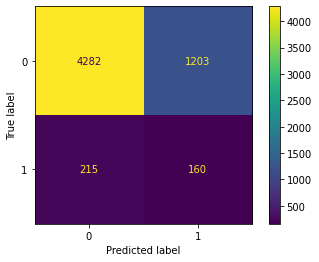

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Submission file

In [57]:
submission = pd.read_csv('sample_submission_KvRh9Sx.csv')

In [58]:
submission.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,1
2,ID58595,1
3,ID58596,1
4,ID58597,1


In [59]:
oot_final.drop(columns = ['policy_id']).shape

(39063, 42)

In [60]:
train_feature = pd.concat([x_train_final, x_test_final], axis = 0)
train_target = pd.concat([y_train, y_test], axis = 0)
train_feature.shape

(58592, 42)

In [61]:
lgbm_best.fit(train_feature, train_target)

LGBMClassifier(colsample_bytree=0.4, is_unbalance=True, learning_rate=0.02,
               max_depth=5, num_leaves=15, objective='binary', random_state=1,
               reg_alpha=7, reg_lambda=1, subsample=0.5)

In [62]:
oot_pred = lgbm_best.predict(oot_final.drop(columns = ['policy_id']))
oot_pred.sum()

9022

In [63]:
submission['is_claim'] = oot_pred

In [64]:
submission.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,0
2,ID58595,0
3,ID58596,0
4,ID58597,0


In [65]:
submission['is_claim'].value_counts(normalize = True)

0    0.76904
1    0.23096
Name: is_claim, dtype: float64

In [66]:
submission.to_csv('submission.csv', index = False)